In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from transformers import TrainingArguments

#Load data
df = pd.read_csv("Resume_Data.csv")
df['AI Score (0-100)'] = df['AI Score (0-100)'].astype(float)

def create_resume_text(row):
    parts = [
        f"Skills: {row['Skills']}",
        f"Experience: {row['Experience (Years)']} years",
        f"Education: {row['Education']}",
        f"Certifications: {row['Certifications']}",
        f"Projects: {row['Projects Count']} projects"
    ]
    return ' | '.join(str(p) for p in parts)

df['resume_text'] = df.apply(create_resume_text, axis=1)
texts = df['resume_text'].tolist()
df['AI Score (0-100)'] /= 100.0
labels = df['AI Score (0-100)'].tolist()

#Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Dataset Class
class ResumeDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

#Train&test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_dataset = ResumeDataset(X_train, y_train)
test_dataset = ResumeDataset(X_test, y_test)

#Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)

#Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="no",
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

#Computation of metrics
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = preds.flatten()*100
    labels = labels.flatten()*100
    rmse = np.sqrt(mean_squared_error(labels, preds))
    r2 = r2_score(labels, preds)
    return {"rmse": rmse, "r2": r2}

#Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

#Training
trainer.train()

#Evaluation
metrics = trainer.evaluate()
print(metrics)

#Save model
trainer.save_model("./saved_model")       # Saves model + training args
tokenizer.save_pretrained("./saved_model")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: xander-links (xander-links-university-of-kwazulu-natal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.037800
1000,0.023200
1500,0.019500
2000,0.016400


{'eval_loss': 0.019965237006545067, 'eval_rmse': 14.12983877296553, 'eval_r2': 0.3098217844963074, 'eval_runtime': 131.8397, 'eval_samples_per_second': 7.585, 'eval_steps_per_second': 0.948, 'epoch': 4.0}


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [ ]:
#Predictions for graphical evaluation
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.flatten() * 100
true_labels = predictions.label_ids.flatten() * 100


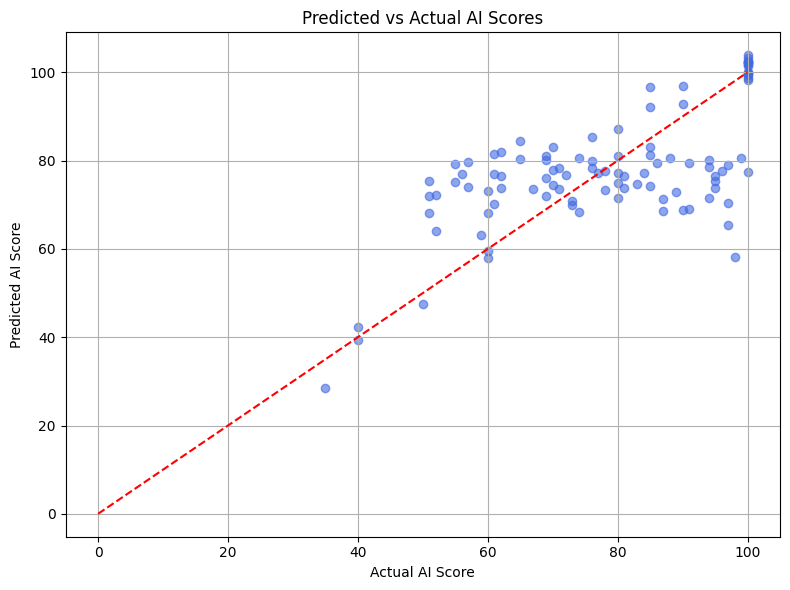

In [ ]:
import matplotlib.pyplot as plt

n = 100
limited_preds = preds[:n]
limited_labels = true_labels[:n]
plt.figure(figsize=(8, 6))
plt.scatter(limited_labels, limited_preds, alpha=0.6, color='royalblue')
plt.plot([0, 100], [0, 100], color='red', linestyle='--')  # reference line y = x
plt.xlabel("Actual AI Score")
plt.ylabel("Predicted AI Score")
plt.title("Predicted vs Actual AI Scores")
plt.grid(True)
plt.tight_layout()
plt.show()

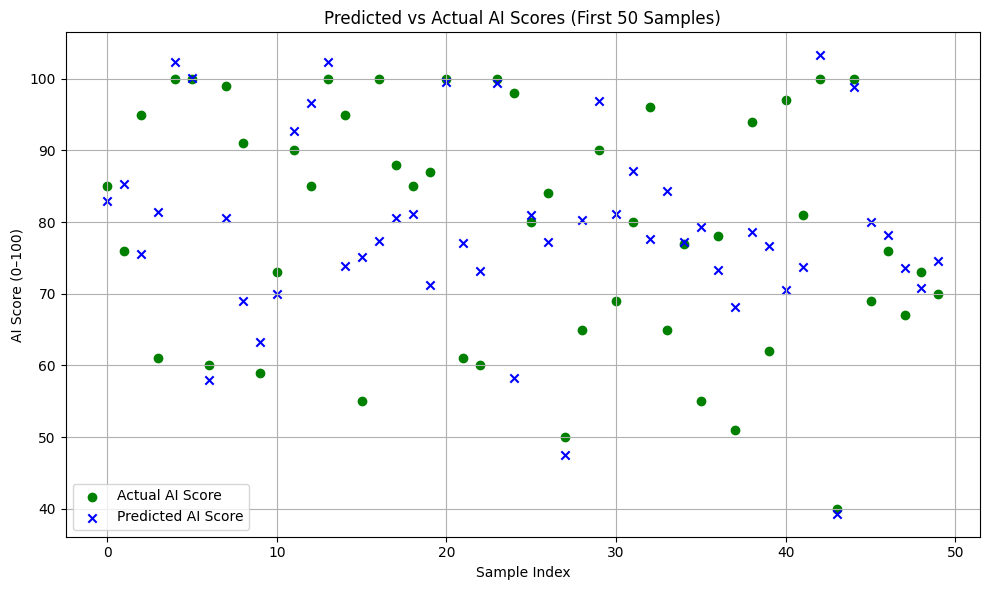

In [ ]:
n = 50
limited_preds = preds[:n]
limited_labels = true_labels[:n]

plt.figure(figsize=(10, 6))
plt.scatter(range(n), limited_labels, label="Actual AI Score", color="green", marker='o')
plt.scatter(range(n), limited_preds, label="Predicted AI Score", color="blue", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("AI Score (0–100)")
plt.title("Predicted vs Actual AI Scores (First 50 Samples)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Loading saved model
model = BertForSequenceClassification.from_pretrained("./saved_model")
tokenizer = BertTokenizer.from_pretrained("./saved_model")
import torch

# Example input
text = "TensorFlow, Pytorch, NLP, Python, 1 years experience, M.Tech, AWS Certification, 1 project"

# Tokenization
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Prediction
with torch.no_grad():
    outputs = model(**inputs)
    predicted_score = outputs.logits.item()  # because num_labels=1

print(f"Predicted AI Score: {predicted_score*100:.2f}")

Predicted AI Score: 39.37
